In [2]:

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import face_recognition

In [3]:
import torch
from torch.autograd import Variable
import time
import os
import sys
import os
from torch import nn
from torchvision import models

In [4]:

class Model(nn.Module):
    def __init__(self, num_classes, latent_dim=2048, lstm_layers=1, hidden_dim=2048, bidirectional=False):
        super(Model, self).__init__()
        model = models.resnext50_32x4d(pretrained=True)
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim, hidden_dim, lstm_layers, bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        batch_size, seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size, seq_length, 2048)
        x_lstm, _ = self.lstm(x, None)
        return fmap, self.dp(self.linear1(x_lstm[:, -1, :]))

In [5]:
from torchvision import transforms
import numpy as np
im_size = 112
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
sm = nn.Softmax()
inv_normalize =  transforms.Normalize(mean=-1*np.divide(mean,std),std=np.divide([1,1,1],std))
def im_convert(tensor):
    """ Display a tensor as an image. """
    image = tensor.to("cpu").clone().detach()
    image = image.squeeze()
    image = inv_normalize(image)
    image = image.numpy()
    image = image.transpose(1,2,0)
    image = image.clip(0, 1)
    cv2.imwrite('./2.png',image*255)
    return image





def predict(model, img, path='./'):
    # Ensure model is on CPU
    model = model.to('cpu')
    
    # Make sure input image is on CPU
    img = img.to('cpu')
    
    # Forward pass
    fmap, logits = model(img)
    
    # Softmax for probabilities
    sm = torch.nn.Softmax(dim=1)
    logits = sm(logits)
    
    # Get predictions and confidence
    _, prediction = torch.max(logits, 1)
    confidence = logits[:, int(prediction.item())].item() * 100
    print('Confidence of prediction:', confidence)
    
    # Get the weight of the softmax layer
    weight_softmax = model.linear1.weight.detach().cpu().numpy()
    
    # Generate heatmap
    idx = np.argmax(logits.detach().cpu().numpy())
    bz, nc, h, w = fmap.shape
    out = np.dot(fmap[-1].detach().cpu().numpy().reshape((nc, h*w)).T, weight_softmax[idx, :].T)
    predict = out.reshape(h, w)
    predict = predict - np.min(predict)
    predict_img = predict / np.max(predict)
    predict_img = np.uint8(255 * predict_img)
    out = cv2.resize(predict_img, (im_size, im_size))
    heatmap = cv2.applyColorMap(out, cv2.COLORMAP_JET)
    
    # Convert and save image
    img = im_convert(img[:, -1, :, :])
    img = np.uint8(img * 255)  # Ensure img is in [0, 255] range
    result = heatmap * 0.5 + img * 0.8
    result = np.clip(result, 0, 255)  # Clip values to [0, 255] range
    cv2.imwrite(path + '1.png', result)
    
    # Normalize for visualization
    result1 = heatmap * 0.5 / 255 + img * 0.8 / 255
    result1 = np.clip(result1, 0, 1)  # Ensure result1 is in [0, 1] range for imshow
    
    # Plot heatmap and original image
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot heatmap
    axes[0].imshow(result1)
    axes[0].set_title('Heatmap')
    axes[0].axis('off')  # Hide axes for better visualization
    
    # Plot original image
    axes[1].imshow(img.squeeze(), cmap='gray')  # Assuming img is grayscale
    axes[1].set_title('Original Image')
    axes[1].axis('off')  # Hide axes for better visualization
    
    plt.show()
    
    return prediction
#img = train_data[100][0].unsqueeze(0)
#predict(model,img)

In [6]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import face_recognition
class validation_dataset(Dataset):
    def __init__(self,video_names,sequence_length = 60,transform = None):
        self.video_names = video_names
        self.transform = transform
        self.count = sequence_length
    def __len__(self):
        return len(self.video_names)
    def __getitem__(self,idx):
        video_path = self.video_names[idx]
        frames = []
        a = int(100/self.count)
        first_frame = np.random.randint(0,a)      
        for i,frame in enumerate(self.frame_extract(video_path)):
            #if(i % a == first_frame):
            faces = face_recognition.face_locations(frame)
            try:
              top,right,bottom,left = faces[0]
              frame = frame[top:bottom,left:right,:]
            except:
              pass
            frames.append(self.transform(frame))
            if(len(frames) == self.count):
              break
        #print("no of frames",len(frames))
        frames = torch.stack(frames)
        frames = frames[:self.count]
        return frames.unsqueeze(0)
    def frame_extract(self,path):
      vidObj = cv2.VideoCapture(path) 
      success = 1
      while success:
          success, image = vidObj.read()
          if success:
              yield image
def im_plot(tensor):
    image = tensor.cpu().numpy().transpose(1,2,0)
    b,g,r = cv2.split(image)
    image = cv2.merge((r,g,b))
    image = image*[0.22803, 0.22145, 0.216989] +  [0.43216, 0.394666, 0.37645]
    image = image*255.0
    plt.imshow(image.astype(int))
    plt.show()

In [38]:
class validation_dataset(Dataset):
    def __init__(self,video_names,sequence_length = 60,transform = None):
        self.video_names = video_names
        self.transform = transform
        self.count = sequence_length
    def __len__(self):
        return len(self.video_names)
    def __getitem__(self,idx):
        video_path = self.video_names[idx]
        frames = []
        a = int(100/self.count)
        first_frame = np.random.randint(0,a) 
        for i,frame in enumerate(self.frame_extract(video_path)):
          frames.append(self.transform(frame))
          if(len(frames) == self.count):
            break
        frames = torch.stack(frames)
        frames = frames[:self.count]
        return frames.unsqueeze(0)
    def frame_extract(self,path):
      vidObj = cv2.VideoCapture(path) 
      success = 1
      while success:
          success, image = vidObj.read()
          if success:
              yield image

In [7]:
import torch
from torchvision import transforms
from torch import nn
from torchvision import models

# Define the transformations
im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Define paths to videos
path_to_videos = ["C:/Projects/DeepfakeDetection/DeepFakeDetection_Dataset/data/000_003.mp4"]



# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize and load model
model = Model(2).to(device)
path_to_model = 'C:/Projects/DeepfakeDetection/model_87_acc_20_frames_final_data.pt'
model.load_state_dict(torch.load(path_to_model, map_location=device,weights_only=True))
model.eval()





C:\Users\abish\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\abish\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

C:\Projects\DeepfakeDetection\Validation\org_cropped\2.mp4
Confidence of prediction: 58.19770693778992


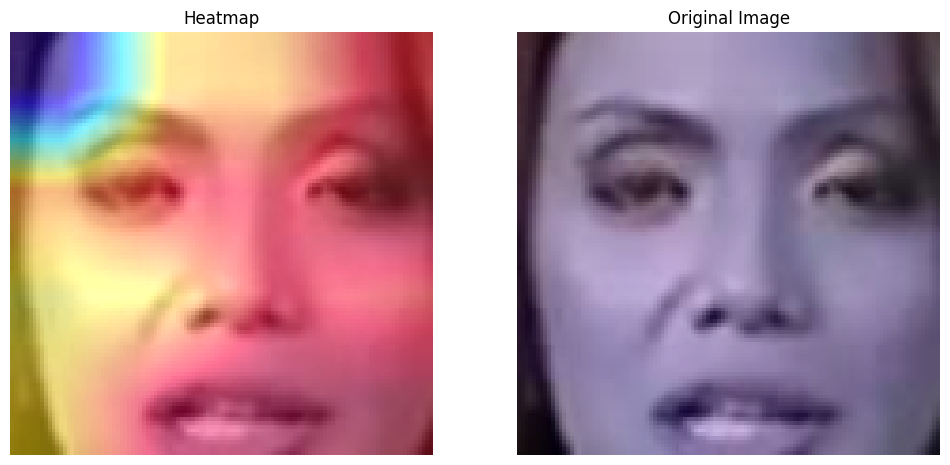

FAKE
C:\Projects\DeepfakeDetection\Validation\Fake\2.mp4
Confidence of prediction: 99.99896287918091


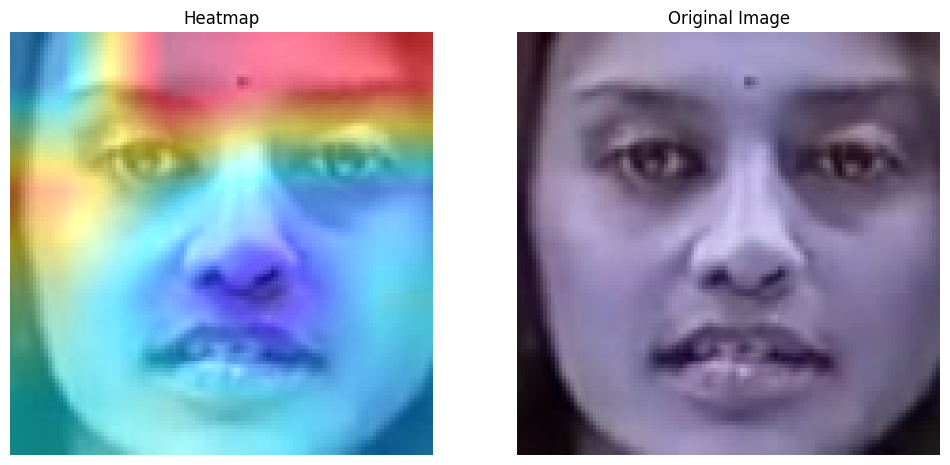

FAKE


In [9]:
path_to_videos = ["C:\Projects\DeepfakeDetection\Validation\org_cropped\\2.mp4","C:\Projects\DeepfakeDetection\Validation\Fake\\2.mp4"]

video_dataset = validation_dataset(path_to_videos, sequence_length=20, transform=train_transforms)

# Make predictions
for i in range(len(path_to_videos)):
    print(path_to_videos[i])
    prediction = predict(model, video_dataset[i], './')
    if prediction[0] == 1:
        print("REAL")
    else:
        print("FAKE")